In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1,filename='run.log')

In [10]:
%time
'''
first we test the core/interface extractor, since it is most essential
'''
import sys
sys.path.append('..')
%matplotlib inline
# output workaround, sometimes necessary
#import matplotlib
#matplotlib.use('Agg')
from eden.converter.graph.gspan import gspan_to_eden
from graphlearn.graphlearn import GraphLearnSampler
from eden.graph import Vectorizer
import matplotlib.pyplot as plt
import itertools
from eden.util import fit, random_bipartition_iter , fit_estimator
from sklearn.linear_model import SGDClassifier
import random


# a vectorizer
vectorizer = Vectorizer( complexity=3 )



# positive set contains 2401 elements, of which we use 30% to test of we cen improve them ,
# the rest is used for the oracle
lenpo=int(2401*.3)


sampler_graph,oracle = random_bipartition_iter(gspan_to_eden('bursi.pos.gspan'),.3)

# we create an oracle
#estimator=make_estimator(oracle,gspan_to_eden('bursi.neg.gspan'))
X=vectorizer.transform(oracle)
X_=X.multiply(-1)
estimator= fit_estimator(SGDClassifier(),X,X_)
print 'estimator ok'


CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 9.06 µs
estimator ok


In [11]:
%%time
import numpy as np
import os
os.nice(19)
# ok we create an iterator over the graphs we want to work with... 
graphs_pos= sampler_graph


# we want to use an increasing part of the test set.. 
percentages=[0.1, 0.25, 0.5, 0.75, 0.9]
#percentages=[0.1]



sampler = GraphLearnSampler(radius_list=[1,2],thickness_list=[1,2])
orires=[]
samplres=[]
for perc in percentages:
    
    originals=[]
    samples=[]
    for e in range(5):
        # we work with count many graphs
        count = int(lenpo*perc)
        # make copy of graphiterator
        # select count random elements
        # triplicate  the count long iterator
        graphs_pos, graphs_pos_ = itertools.tee(graphs_pos)

        # i pick only perc many :) 
        graphs_pos_,zzz = random_bipartition_iter(graphs_pos_, perc )    
        graphs_pos_,graphs_pos__,graphs_pos___ = itertools.tee(graphs_pos_,3)

        # do sampling
        sampler.fit(graphs_pos__, n_jobs=-1, core_interface_pair_remove_threshold=3, interface_remove_threshold=3)

        n_steps=20
        sampling_factor=3 #how many samples per seed
        sampling_interval=np.ceil([n_steps/sampling_factor])
        improved_graphs = sampler.sample(graphs_pos_,
                            same_radius=False,
                            same_core_size=True,
                            select_cip_max_tries=200,
                            batch_size=30,
                            n_steps=n_steps,
                            sampling_interval=sampling_interval,
                            n_jobs=-1,
                            accept_annealing_factor=1.0,
                            probabilistic_core_choice=True,
                            generatormode=True)

        #calculate the score of the improved versions
        #calculate score of the originals
        avg_imp=np.mean( [estimator.decision_function(e) for e in vectorizer.transform(improved_graphs) ] )
        avg_ori=np.mean( [estimator.decision_function(e) for e in vectorizer.transform(graphs_pos___)] )
        samples.append(avg_imp)
        originals.append(avg_ori)
        
    orires.append(originals)
    samplres.append(samples)

Traceback (most recent call last):
  File "/usr/lib64/python2.7/logging/handlers.py", line 77, in emit
    self.doRollover()
  File "/usr/lib64/python2.7/logging/handlers.py", line 136, in doRollover
    os.rename(sfn, dfn)
OSError: [Errno 2] No such file or directory
Logged from file graphlearn.py, line 390
/home/martners/.local/lib/python2.7/site-packages/sklearn/calibration.py:398: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/martners/.local/lib/python2.7/site-packages/sklearn/calibration.py:408: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/martners/.local/lib/python2.7/site-packages/sklearn/calibration.py:410: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
Traceback (most recent call last):
  File "/usr/lib64/python2.7/logging/handlers.py", line 77, in emit
    self.doRollover()
  File "/usr/lib64/python2.7/logging/handlers.py", line 135, in doRollover
    os.remove(d

CPU times: user 27min 40s, sys: 49.1 s, total: 28min 29s
Wall time: 1h 34min 46s


Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib64/python2.7/logging/handlers.py", line 77, in emit
  File "/usr/lib64/python2.7/logging/handlers.py", line 77, in emit
    self.doRollover()
    self.doRollover()
  File "/usr/lib64/python2.7/logging/handlers.py", line 136, in doRollover
  File "/usr/lib64/python2.7/logging/handlers.py", line 136, in doRollover
    os.rename(sfn, dfn)
    os.rename(sfn, dfn)
OSError: [Errno 2] No such file or directory
OSError: [Errno 2] No such file or directory
Logged from file graphlearn.py, line 225
Logged from file graphlearn.py, line 225


Original: [[1.8580980082858365, 1.8580980082858365, 1.8580980082858365, 1.8580980082858365, 1.8580980082858365], [1.8578705512646341, 1.8578705512646341, 1.8578705512646341, 1.8578705512646341, 1.8578705512646341], [1.8650976083899928, 1.8650976083899928, 1.8650976083899928, 1.8650976083899928, 1.8650976083899928], [1.8675670886187281, 1.8675670886187281, 1.8675670886187281, 1.8675670886187281, 1.8675670886187281], [1.866183441756865, 1.866183441756865, 1.866183441756865, 1.866183441756865, 1.866183441756865]]
Sampled: [[2.0269599874701711, 1.9582041385209175, 1.9271852352398249, 1.9669066452569091, 1.9951731056735769], [1.9536121014561709, 1.973862381752163, 1.9390310427609196, 1.9449990489135107, 1.9675374571077326], [1.9490957341052879, 1.9588124096541837, 1.9475654482771911, 1.9461881929134366, 1.9516718341878712], [1.9550378356739522, 1.9584079901368501, 1.9444332566311671, 1.9584356763536441, 1.955952540486473], [1.9493302114078404, 1.9598844761865282, 1.9588991713969355, 1.95819

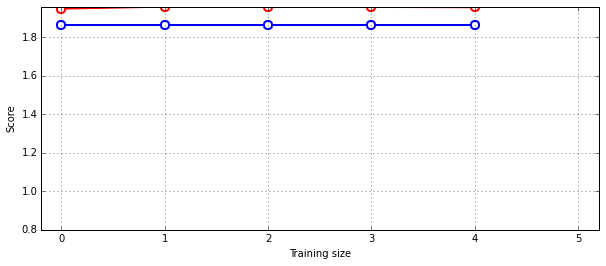

In [12]:
print "Original:", orires
print "Sampled:", samplres
# ok alle infos sollten jetzt da sein um diesen supergraph zu zeichnen

from graphlearn.utils.draw import plot_charts
plot_charts(originals, data2=samples, xlabel="Training size", ylabel="Score", size=(10,4), log_scale=False)

In [13]:
from graphlearn.utils.draw import draw_learning_curve

/home/martners/.local/lib/python2.7/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


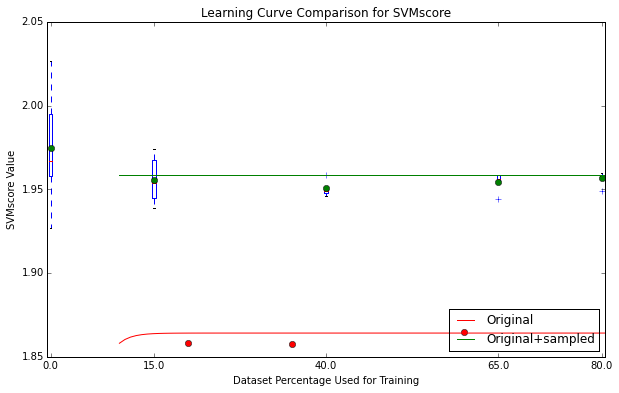

In [14]:
draw_learning_curve(data_A=orires,data_B=samplres,x=percentages,measure='SVMscore')